In [36]:
import jax
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [37]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
def f(x):
    return x - 10 * jnp.cos(x) * jnp.sin(x) + x ** 3


def sample_observations(key, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=3.0):
    key_x, key_y, key_shuffle, key_corrupted = jax.random.split(key, 4)
    is_corrupted = jax.random.bernoulli(key_corrupted, p=0.05, shape=(n_obs,))
    
    x_noise = jax.random.normal(key_x, (n_obs,)) * x_noise
    y_noise = jax.random.normal(key_y, (n_obs,)) * y_noise
    x = jnp.linspace(xmin, xmax, n_obs) + x_noise
    y = f(x) + y_noise
    y = y * (1 - is_corrupted) + 30 * is_corrupted
    
    X = jnp.c_[x, y]
    shuffled_ixs = jax.random.permutation(key_shuffle, jnp.arange(n_obs))
    x, y = jnp.array(X[shuffled_ixs, :].T)
    
    return x, y


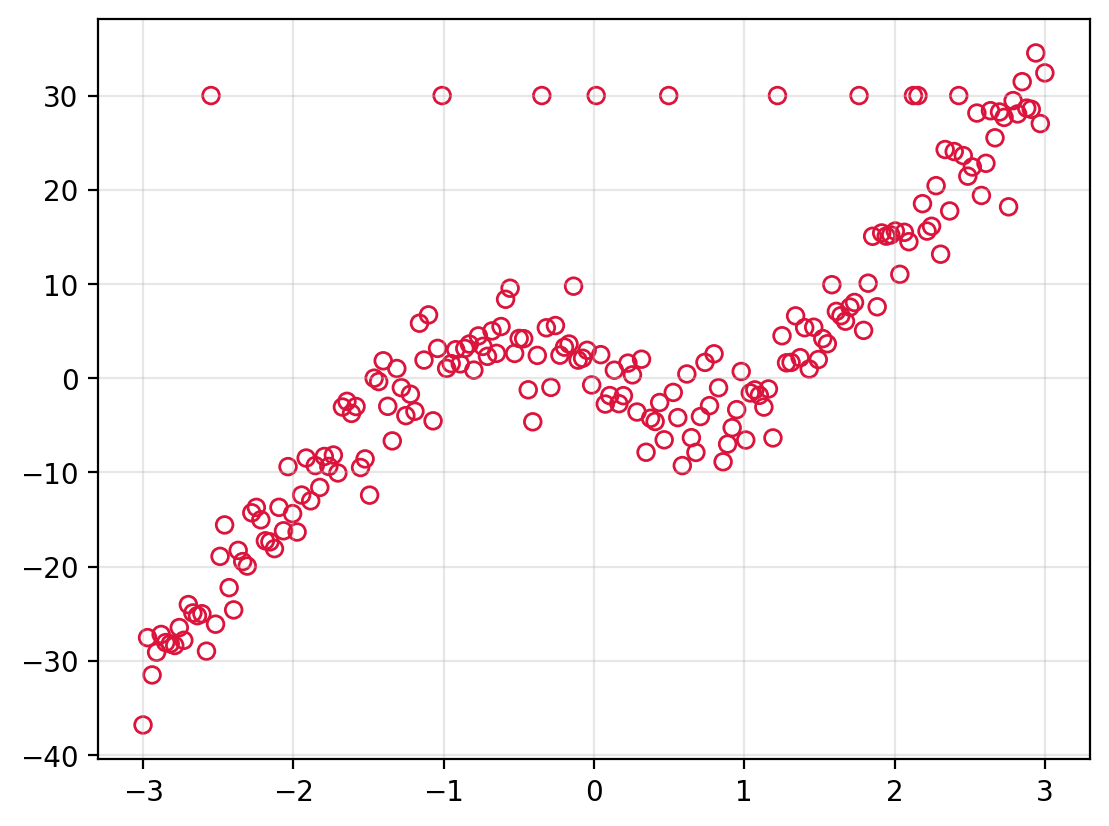

In [39]:
key = jax.random.PRNGKey(314)
key_train, key_sample_obs, key_eval = jax.random.split(key, 3)

n_obs = 200
xmin, xmax = -3, 3
sigma_y = 3.0
x, y = sample_observations(key_sample_obs, f, n_obs, xmin, xmax, x_noise=0, y_noise=sigma_y)
xtest = jnp.linspace(x.min(), x.max(), n_obs)
plt.scatter(x, y, edgecolors="crimson", color="none")
plt.grid(alpha=0.3)


In [40]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(6)(x)
        x = nn.relu(x)
        x = nn.Dense(6)(x)
        x = nn.relu(x)
        x = nn.Dense(6)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x
model = MLP()
params_init = model.init(key_train, x[:, None])


In [41]:
from rebayes_mini import callbacks
from rebayes_mini.methods import gauss_filter as gf
from rebayes_mini.methods import robust_filter as rfilter
from rebayes_mini.methods import generalised_bayes_filter as gbfilter

In [42]:
def latent_fn(x): return x

In [43]:
# agent_ekf = gf.GaussianFilter(
#     model.apply, dynamics_covariance=1e-4, variance=1.0
    
# )

agent_ekf = gf.ExtendedKalmanFilter(
    latent_fn, model.apply, dynamics_covariance=1e-4, observation_covariance=1.0 * jnp.eye(1)
    
)

bel_init = agent_ekf.init_bel(params_init, cov=1.0)
bel_ekf, hist_bel_ekf = agent_ekf.scan(bel_init, y, x[:, None], callbacks.get_updated_bel)
yhat_ekf = agent_ekf.vobs_fn(bel_ekf.mean, xtest[:, None]).ravel()

In [44]:
agent_rekf = rfilter.ExtendedRobustKalmanFilter(
    latent_fn, model.apply, dynamics_covariance=1e-4, prior_observation_covariance=1.0* jnp.eye(1),
    noise_scaling=1.0,
    n_inner=5
)

bel_init = agent_rekf.init_bel(params_init, cov=1.0)
bel_rekf, hist_bel_rekf = agent_rekf.scan(bel_init, y, x[:, None], callbacks.get_updated_bel)
yhat_rekf = agent_rekf.vobs_fn(bel_rekf.mean, xtest[:, None]).ravel()

In [47]:
agent_imq = gbfilter.IMQFilter(
    model.apply, dynamics_covariance=1e-4, observation_covariance=1.0,
    soft_threshold=1.0
)

bel_init = agent_imq.init_bel(params_init, cov=1.0)
bel_imq, hist_bel_imq = agent_imq.scan(bel_init, y, x[:, None], callbacks.get_updated_bel)
yhat_imq = agent_imq.link_fn(bel_imq.mean, xtest[:, None]).ravel()

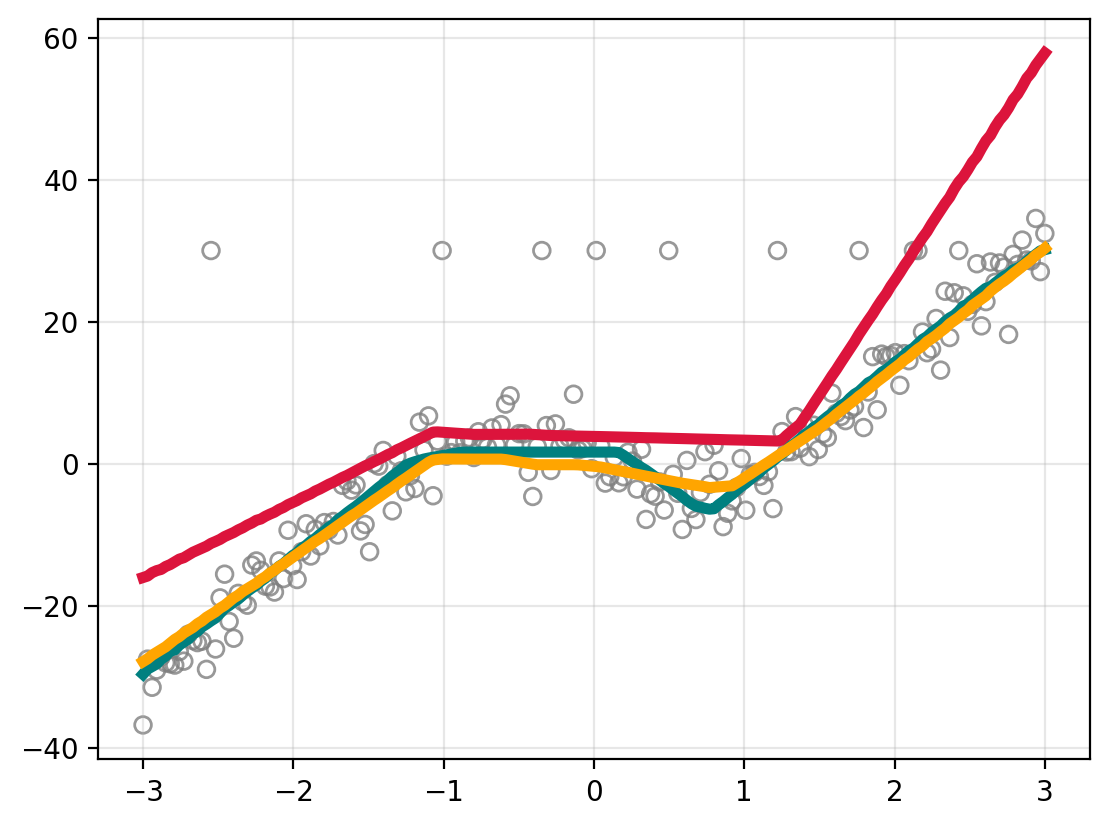

In [52]:
plt.scatter(x, y, edgecolors="tab:gray", c="none", alpha=0.8)
plt.plot(xtest, yhat_ekf, c="crimson", linewidth=4, label="EKF")
plt.plot(xtest, yhat_rekf, c="teal", linewidth=4, label="Robust EKF")
plt.plot(xtest, yhat_imq, c="orange", linewidth=4, label="IMQ")
plt.grid(alpha=0.3)